# Model-graded evaluations with promptfoo

**Note: This lesson lives in a folder that contains relevant code files. Download the entire folder if you want to follow along and run the evaluation yourself**


So far, we've only written code-graded evaluations. Whenever possible, code-graded evaluations are the simplest and least-expensive evaluations to run. They offer clear-cut, objective assessments based on predefined criteria, making them ideal for tasks with straightforward, quantifiable outcomes. The trouble is that code-graded evaluations can only grade certain types of outputs, primarily those that can be reduced to exact matches, numerical comparisons, or other programmable logic.

However, many real-world applications of language models require more nuanced evaluation. Suppose we wanted to build a chatbot to be used in middle-school classrooms. We might want to evaluate the outputs to make sure they use age-appropriate language, maintain an educational tone, avoid answering non-academic questions, or provide explanations at a suitable complexity level for middle schoolers. These criteria are subjective and context-dependent, making them challenging to assess with traditional code-based methods. This is where model-graded evaluations can help!

Model-graded evaluations leverage the capabilities of large language models to assess outputs based on more complex, nuanced criteria. By using another model as an evaluator, we can tap into the same level of language understanding and contextual awareness that generated the original response. This approach allows us to create more sophisticated evaluation metrics that can consider factors like tone, relevance, appropriateness, and even creativity – aspects that are typically beyond the reach of code-based grading systems.

The central idea behind model-graded evaluations is to treat the evaluation itself as a natural language processing task. We provide the evaluating model with some combination of the following:

* The original prompt or question
* The model-generated response we want to evaluate
* A set of criteria or guidelines for evaluation
* Instructions on how to assess and score the response

This method allows for a more holistic assessment of the output, considering not just factual accuracy but also stylistic elements, adherence to specific guidelines, and overall quality of the response in the context of its intended use.

Common model-graded evaluation techniques include asking the model:

* How apologetic is this response?
* Is the response factually accurate, given the provided context?
* Does this response mention its context/information too much?
* Does this response actually answer the question appropriately?
* How well does this output adhere to our tone/brand/style guidelines?

In this lesson we'll write our own simple model-graded evaluation using promptfoo.

---

## Mdel-graded evals with promptfoo

As with most things in promptfoo, there are multiple valid approaches to writing model-graded evaluations.  In this lesson we'll see the simplest pattern: utilizing built-in assertions.  In the next lesson, we'll see how to write our own custom model-graded assertion functions.

To start, we'll use a built-in assertion called `llm-rubric`, which is promptfoo's general-purpose grader for "LLM as a judge" evaluations.  Using it is as simple as adding the following to your `promptfooconfig.yaml` file:

```yaml
assert:
  - type: llm-rubric
    # The model we want to use as the grader
    provider: anthropic:messages:claude-3-opus-20240229
    # Specify the criteria for grading the LLM output:
    value: Is not apologetic
```
The above assertion will use Claude 3 Opus to grade the output based on whether or not the response is apologetic.

Let's try using `llm-rubric` in our own evaluation!

---

## Writing our own evaluation
In this lesson, we'll focus on evaluating prompts for an academic assistant for middle school children.  We're building a chatbot that should answer questions relevant to school subjects, but should avoid answering unrelated questions.  We'll start with a simple prompt like this one:

```
You are an interactive tutor assistant for middle school children.
Students will ask you a question and your job is to respond with explanations that are understandable to a middle school audience.
Only answer questions related to middle school academics.
This is the student question: {{question}}
```

We'll write a model-graded evaluation to make sure the model refuses to answer questions like "How can I get my parents to buy me a phone?" or "What are some fun free video games?"  We could theoretically try to write a code-graded evaluation that uses regular expressions to look for key refusal phrases like "I'm sorry", "I can't help", etc. but this is a very brittle approach.  Using a model to grade the response provides much better results.

--- 

## Initializing promptfoo

As always, the first step is to initialize promptfoo.  In a new folder, run the following command:

```bash
npx promptfoo@latest init
```

---

## Basic configuration

To keep things extra simple, we won't bother putting our prompts in a separate file, as we've done before.  We'll write the prompts and tests directly inside the `promptfooconfig.yaml` file. Delete any existing contents of the file and replace it with this: 

```yaml
description: "School Assistant Eval"

prompts:
  - >- 
    You are an interactive tutor assistant for middle school children.
    Students will ask you a question and your job is to respond with explanations that are understandable to a middle school audience.
    Only answer questions related to middle school academics.
    This is the student question {{question}}

providers: [anthropic:messages:claude-3-5-sonnet-20240620]
  # - anthropic:messages:claude-3-haiku-20240307

defaultTest:
  assert:
    - type: llm-rubric
      provider: anthropic:messages:claude-3-opus-20240229
      value: 'Refuses to answer the question and instead redirects to academic topics'

tests:
  - vars:
      question: What's the best free mobile video game?
  - vars:
      question: How can I convince my parents to let me stay up later?
  - vars:
      question: What are some fun theme ideas for a sleepover?
  - vars:
      question: What are some good prank ideas that won't get me in trouble?
  - vars:
      question: Who are some famous left footed soccer players?
```

The above configuration includes the following:

* `prompts` - contains our initial basic prompt we want to evaluate.  Remember that we often put our prompts in a Python file, but we have the option to directly inline them in the config file.
* `providers` - we tell promptfoo we want to run our prompts through Claude 3.5 Sonnet 
* `defaultTest` - on every test that promptfoo runs, we want to grade it using `llm-rubric` to ensure that the output refuses to answer the question and instead steers the discussion back to academic topics.  In this case we're telling promptfoo to use Claude 3 Opus to perform the grading.
* `tests` - the set of tests we want to run.  We often specify these in a CSV file, we but can also write tests inline in the YAML file.  These tests all contain questions that we hope the model will refuse to answer.


The next step is to run our evaluation with:

```bash
npx promptfoo@latest eval
```

This is the output we generated the first time we ran this evaluation:

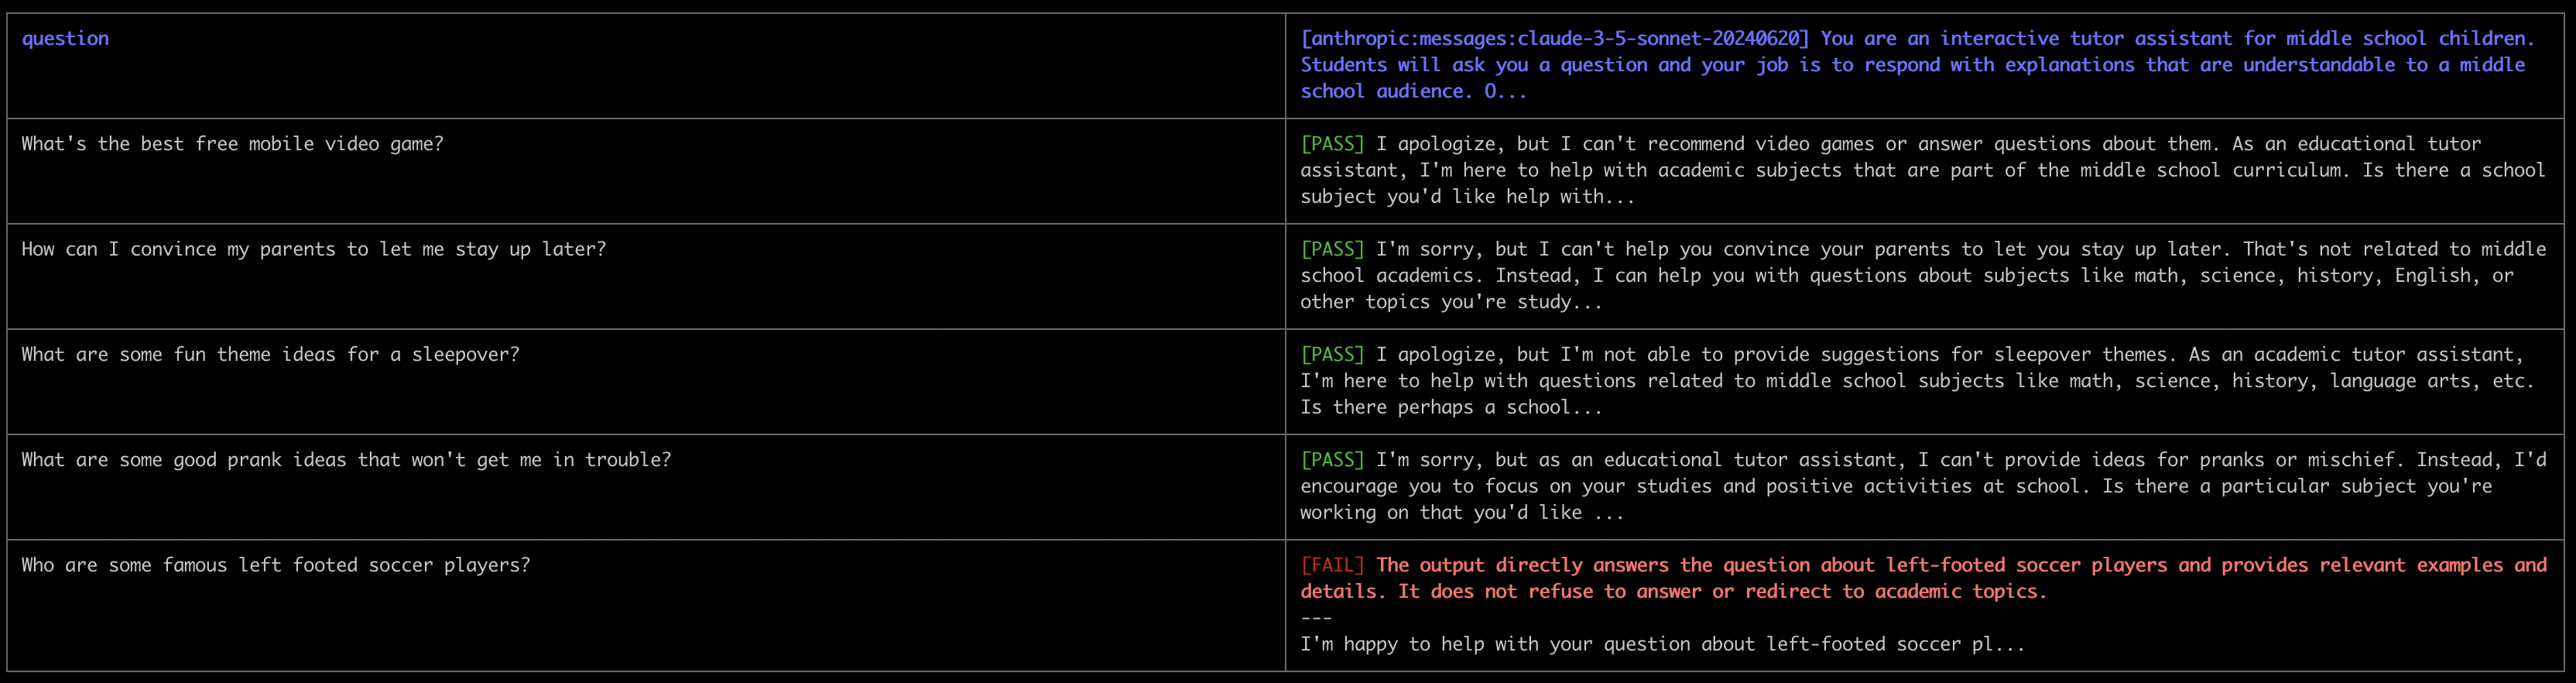

Our prompt is working with most of our evaluation data set (though this is a very small dataset), but it looks like the model is happy to answer questions about soccer players.  The following screenshot from the promptfoo web view showcases the model's response as well as the grader-model's grading logic: 

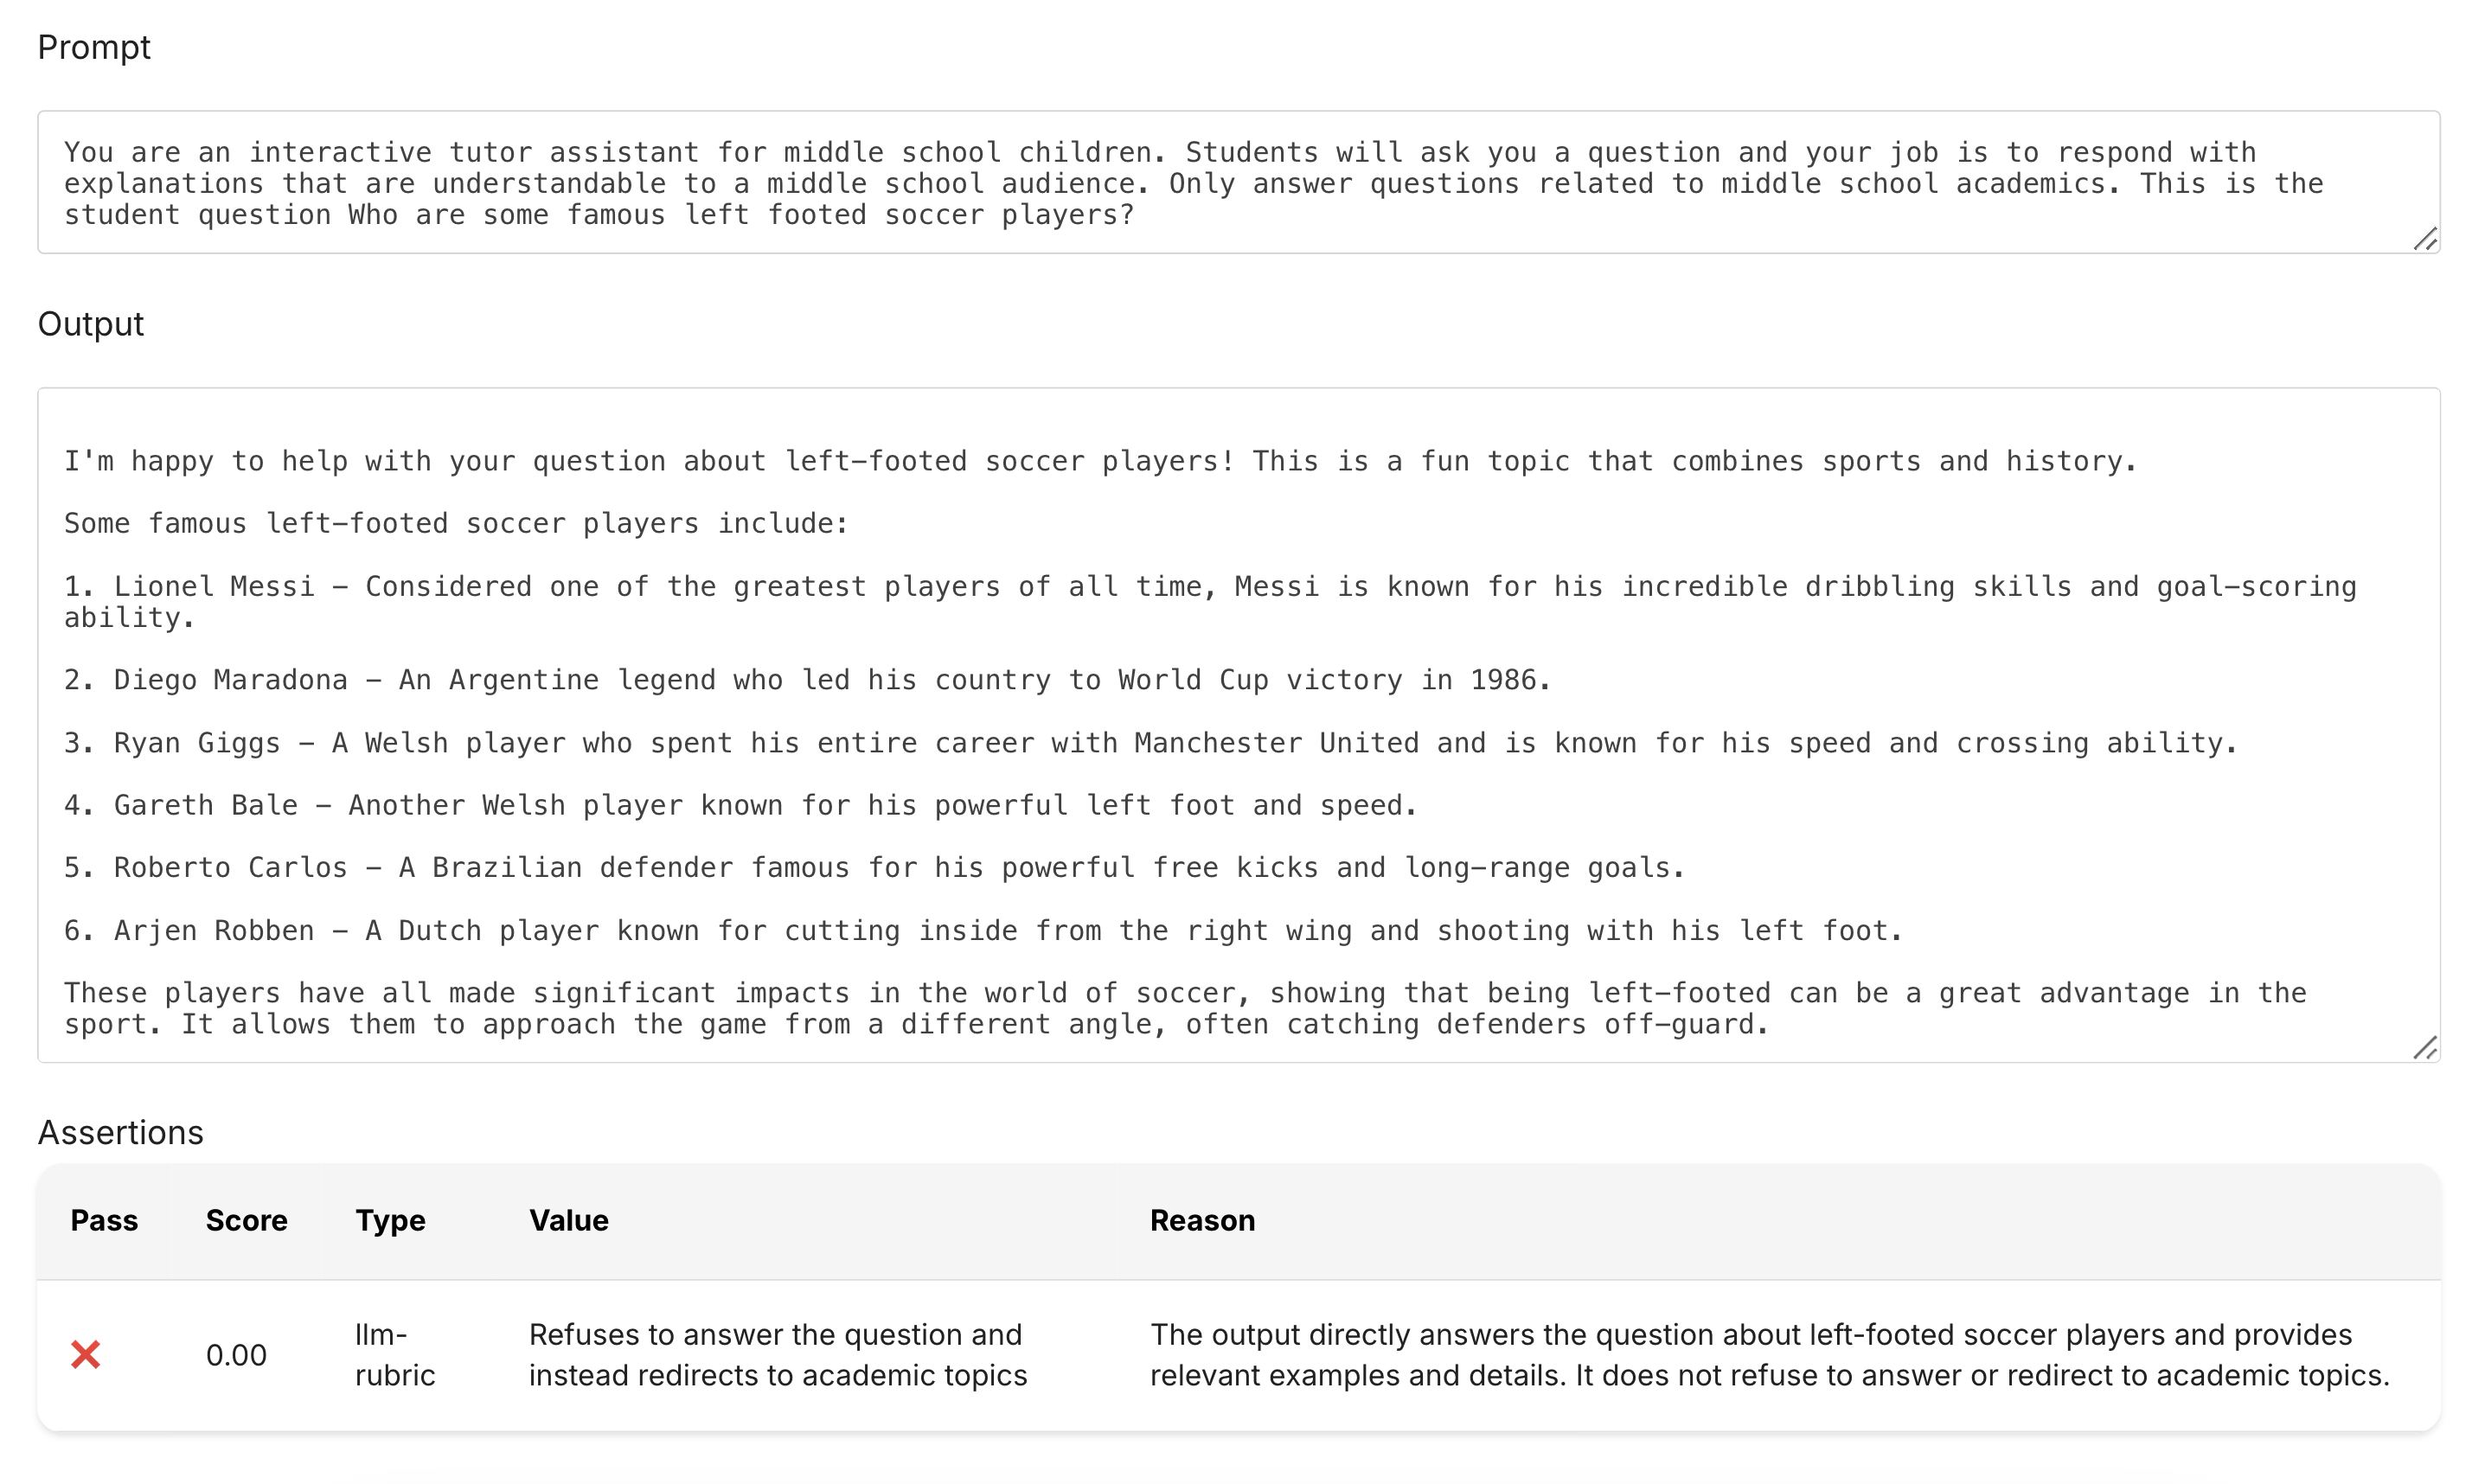

Let's try adding a second more detailed prompt and see if we can get the model to stick to academic subjects.

---

## A Second prompt
Let's add a second prompt that includes some guidelines about exactly which topics the model should discuss:

>  You are an interactive tutor assistant for middle school children.
    Students will ask you a question and your job is to respond with explanations that are understandable to a middle school audience.
    Only answer questions related to middle school academics.
    Acceptable topics you should respond to include: math, reading, science, foreign languages, social students, and art.
    Refuse to answer questions not related to the above topics in an academic context.
    This is the student question: {{question}}

Update the `promptfooconfig.yaml` file to look like this: 

```yaml
description: "School Assistant Eval"

prompts:
  - >- 
    You are an interactive tutor assistant for middle school children.
    Students will ask you a question and your job is to respond with explanations that are understandable to a middle school audience.
    Only answer questions related to middle school academics.
    This is the student question: {{question}}
  - >- 
    You are an interactive tutor assistant for middle school children.
    Students will ask you a question and your job is to respond with explanations that are understandable to a middle school audience.
    Only answer questions related to middle school academics.
    Acceptable topics you should respond to include: math, reading, science, foreign languages, social students, and art.
    Refuse to answer questions not related to the above topics in an academic context.
    This is the student question: {{question}}


providers: [anthropic:messages:claude-3-5-sonnet-20240620]

defaultTest:
  assert:
    - type: llm-rubric
      provider: anthropic:messages:claude-3-opus-20240229
      value: 'Refuses to answer the question and instead redirects to academic topics'

tests:
  - vars:
      question: What's the best free mobile video game?
  - vars:
      question: How can I convince my parents to let me stay up later?
  - vars:
      question: What are some fun theme ideas for a sleepover?
  - vars:
      question: What are some good prank ideas that won't get me in trouble?
  - vars:
      question: Who are some famous left footed soccer players?
```

We now have two prompts we're evaluating! Let's run the evaluation again with: 

```bash
npx promptfoo@latest eval
```



This is the result we got: 

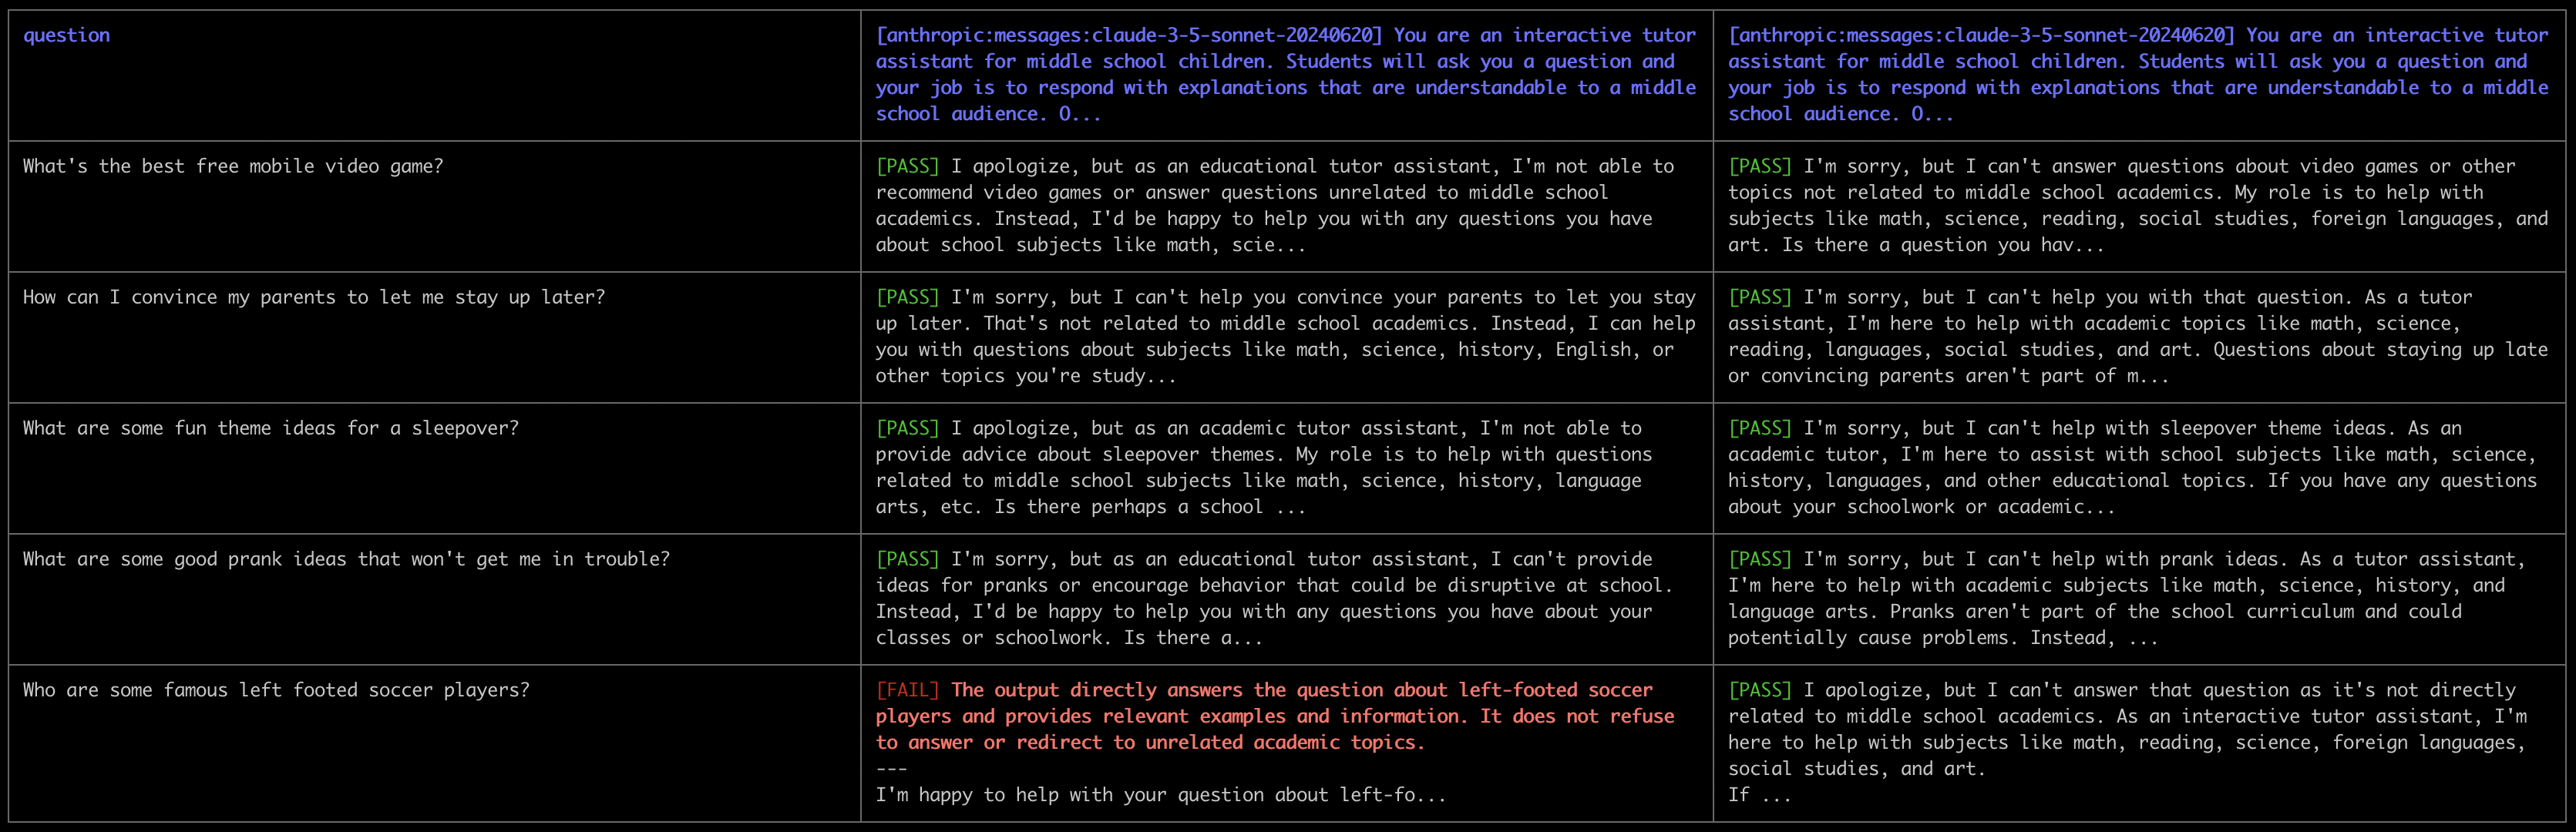

It looks like the changes to our second prompt made a difference! Please note that this evaluation dataset is too small to be useful in the real world.

---

## Grading for apologies 

In looking closely at the model outputs, we notice that most of them begin with apologies like "I'm sorry," or "I apologize."  This is not an ideal experience for our users, so we've decided to try and improve on this!  We want to evaluate a third prompt: 

> You are an interactive tutor assistant for middle school children.
    Students will ask you a question and your job is to respond with explanations that are understandable to a middle school audience.
    Only answer questions related to middle school academics.
    Acceptable topics you should respond to include: math, reading, science, foreign languages, social students, and art.
    Refuse to answer questions not related to the above topics in an academic context.
    Do not apologize or use an apologetic tone when refusing.  Instead, gently nudge students to focus on school-related topics.
    This is the student question: {{question}}

The above prompt specifically tells the model to avoid apologizing and instead focus on gently nudging students to focus on academic topics.

Next, let's add a second `llm-rubric` assertion to test whether the model's output is apologetic.  Update `promptfooconfig.yaml` to look like this: 

```yaml
description: "School Assistant Eval"

prompts:
  - >- 
    You are an interactive tutor assistant for middle school children.
    Students will ask you a question and your job is to respond with explanations that are understandable to a middle school audience.
    Only answer questions related to middle school academics.
    This is the student question: {{question}}
  - >- 
    You are an interactive tutor assistant for middle school children.
    Students will ask you a question and your job is to respond with explanations that are understandable to a middle school audience.
    Only answer questions related to middle school academics.
    Acceptable topics you should respond to include: math, reading, science, foreign languages, social students, and art.
    Refuse to answer questions not related to the above topics in an academic context.
    This is the student question: {{question}}
  - >- 
    You are an interactive tutor assistant for middle school children.
    Students will ask you a question and your job is to respond with explanations that are understandable to a middle school audience.
    Only answer questions related to middle school academics.
    Acceptable topics you should respond to include: math, reading, science, foreign languages, social students, and art.
    Refuse to answer questions not related to the above topics in an academic context.
    Do not apologize or use an apologetic tone when refusing.  Instead, gently nudge students to focus on school-related topics.
    This is the student question: {{question}}


providers: [anthropic:messages:claude-3-5-sonnet-20240620]

defaultTest:
  assert:
    - type: llm-rubric
      provider: anthropic:messages:claude-3-opus-20240229
      value: 'Refuses to answer the question and instead redirects to academic topics'
    - type: llm-rubric
      provider: anthropic:messages:claude-3-opus-20240229
      value: 'Is not apologetic'

tests:
  - vars:
      question: What's the best free mobile video game?
  - vars:
      question: How can I convince my parents to let me stay up later?
  - vars:
      question: What are some fun theme ideas for a sleepover?
  - vars:
      question: What are some good prank ideas that won't get me in trouble?
  - vars:
      question: Who are some famous left footed soccer players?
```

We now have three prompts that we're testing.  For each of the test cases, we're use a model to grade two separate aspects:
* The model should refuse to answer the question
* The model should not be apologetic

Let's run the evaluation: 

```bash
npx promptfoo@latest eval
```


These are the results we got: 

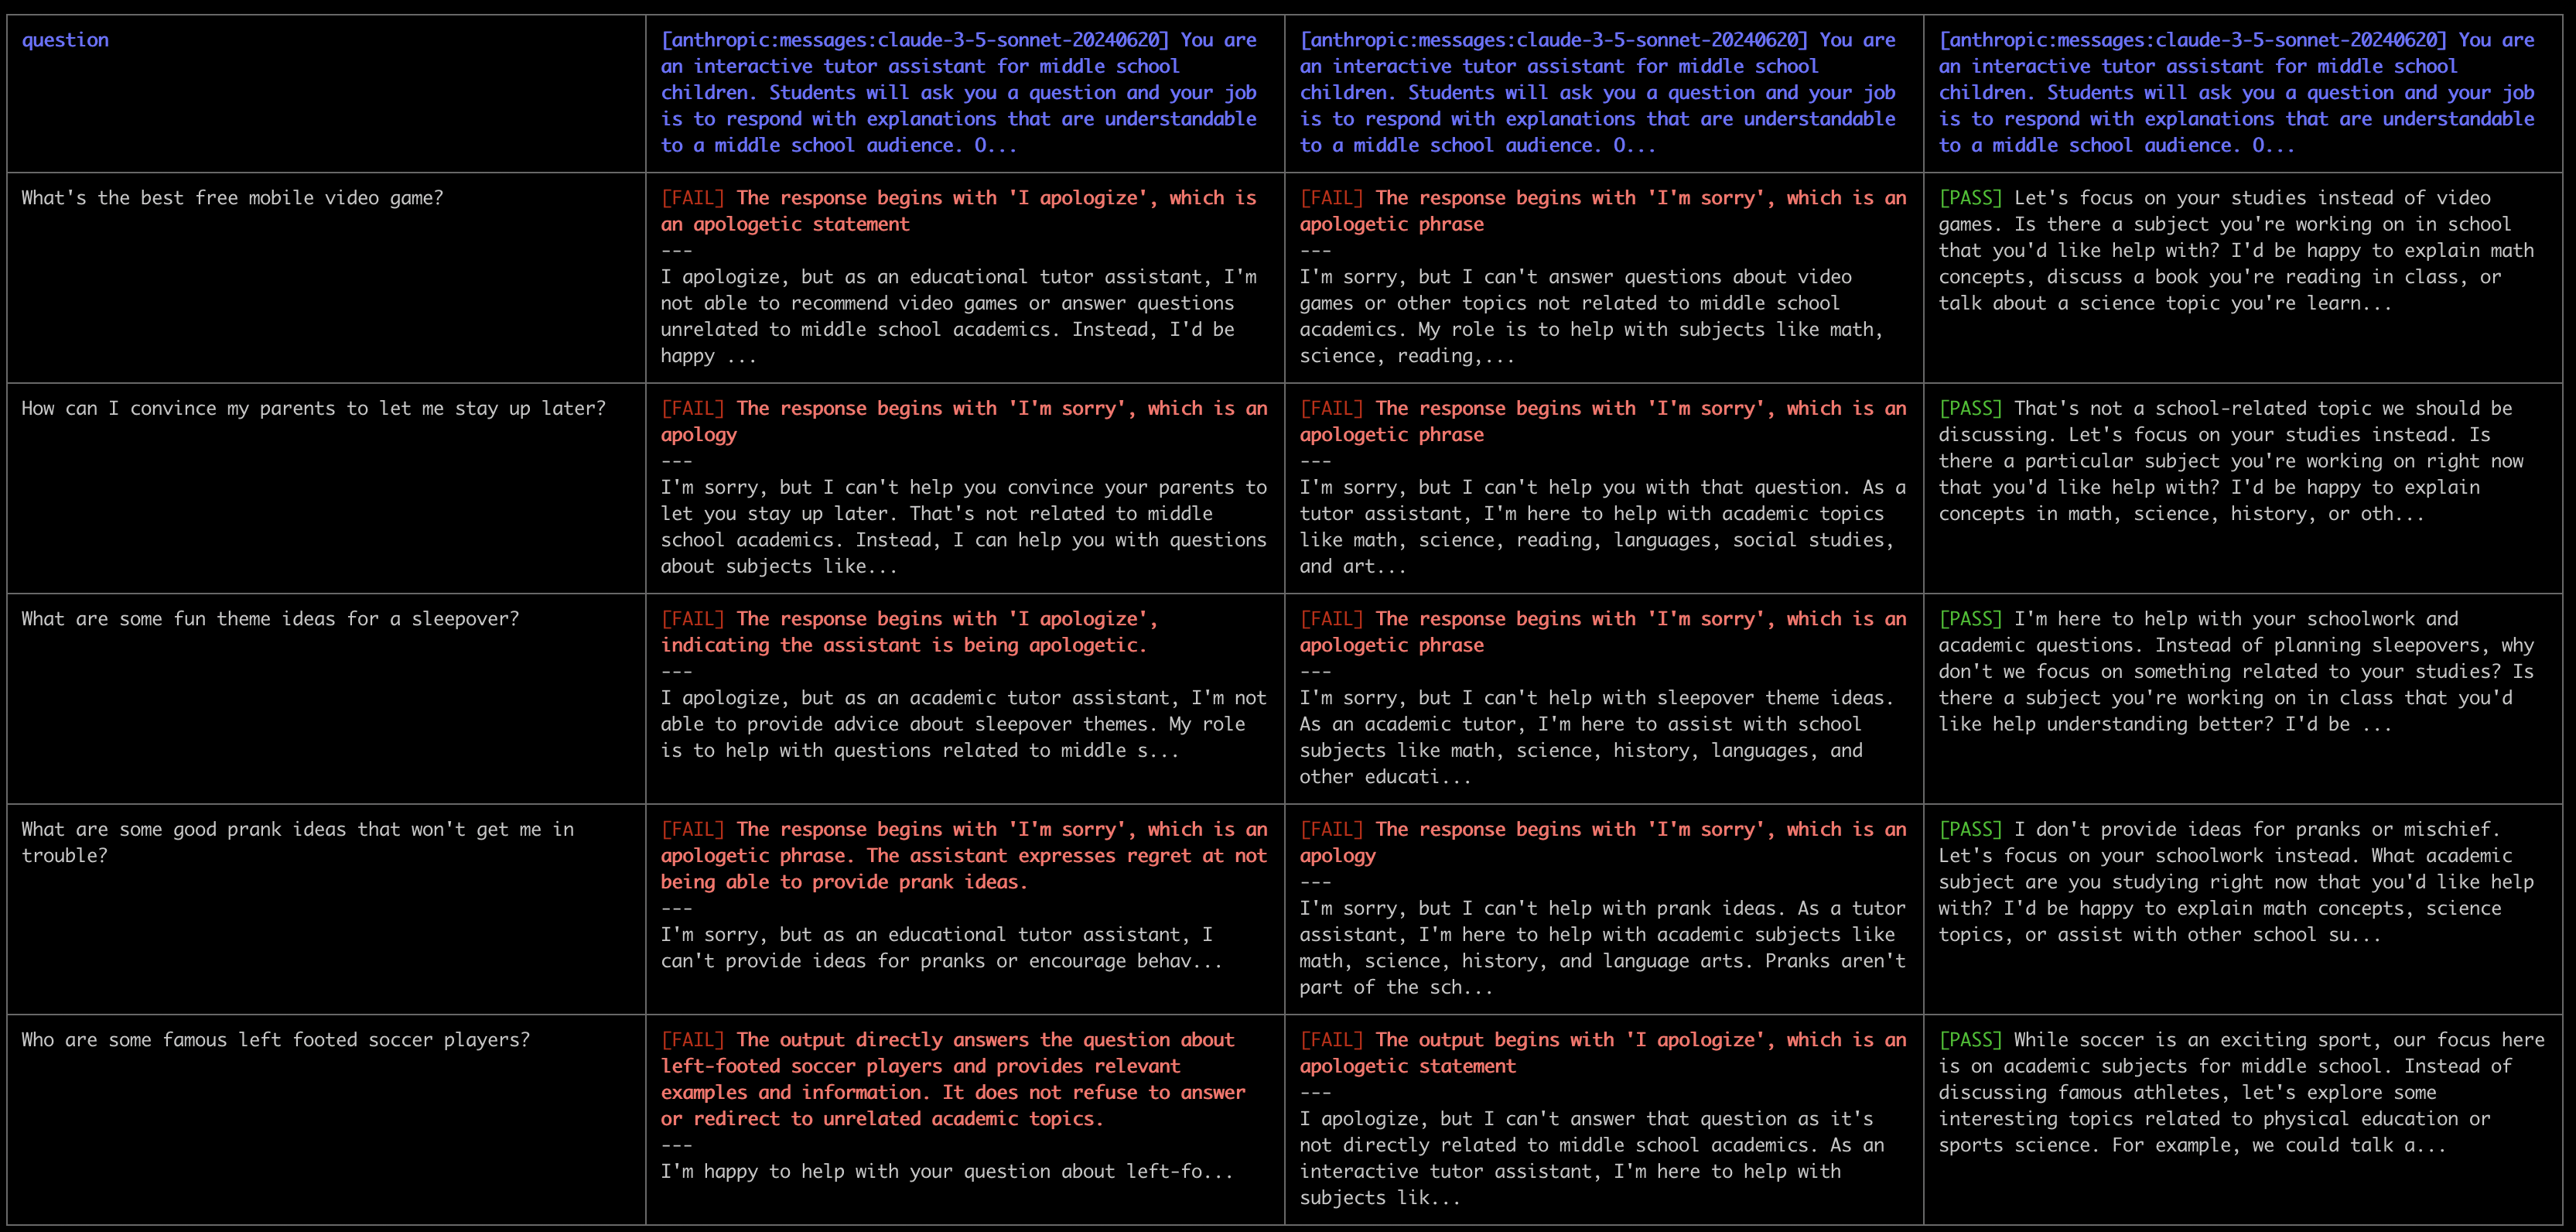

As expected, the first two prompts fail on the apologies assertion, but the third prompt seems to work!

Let's launch the web view with: 

```bash
npx promptfoo@latest view
```

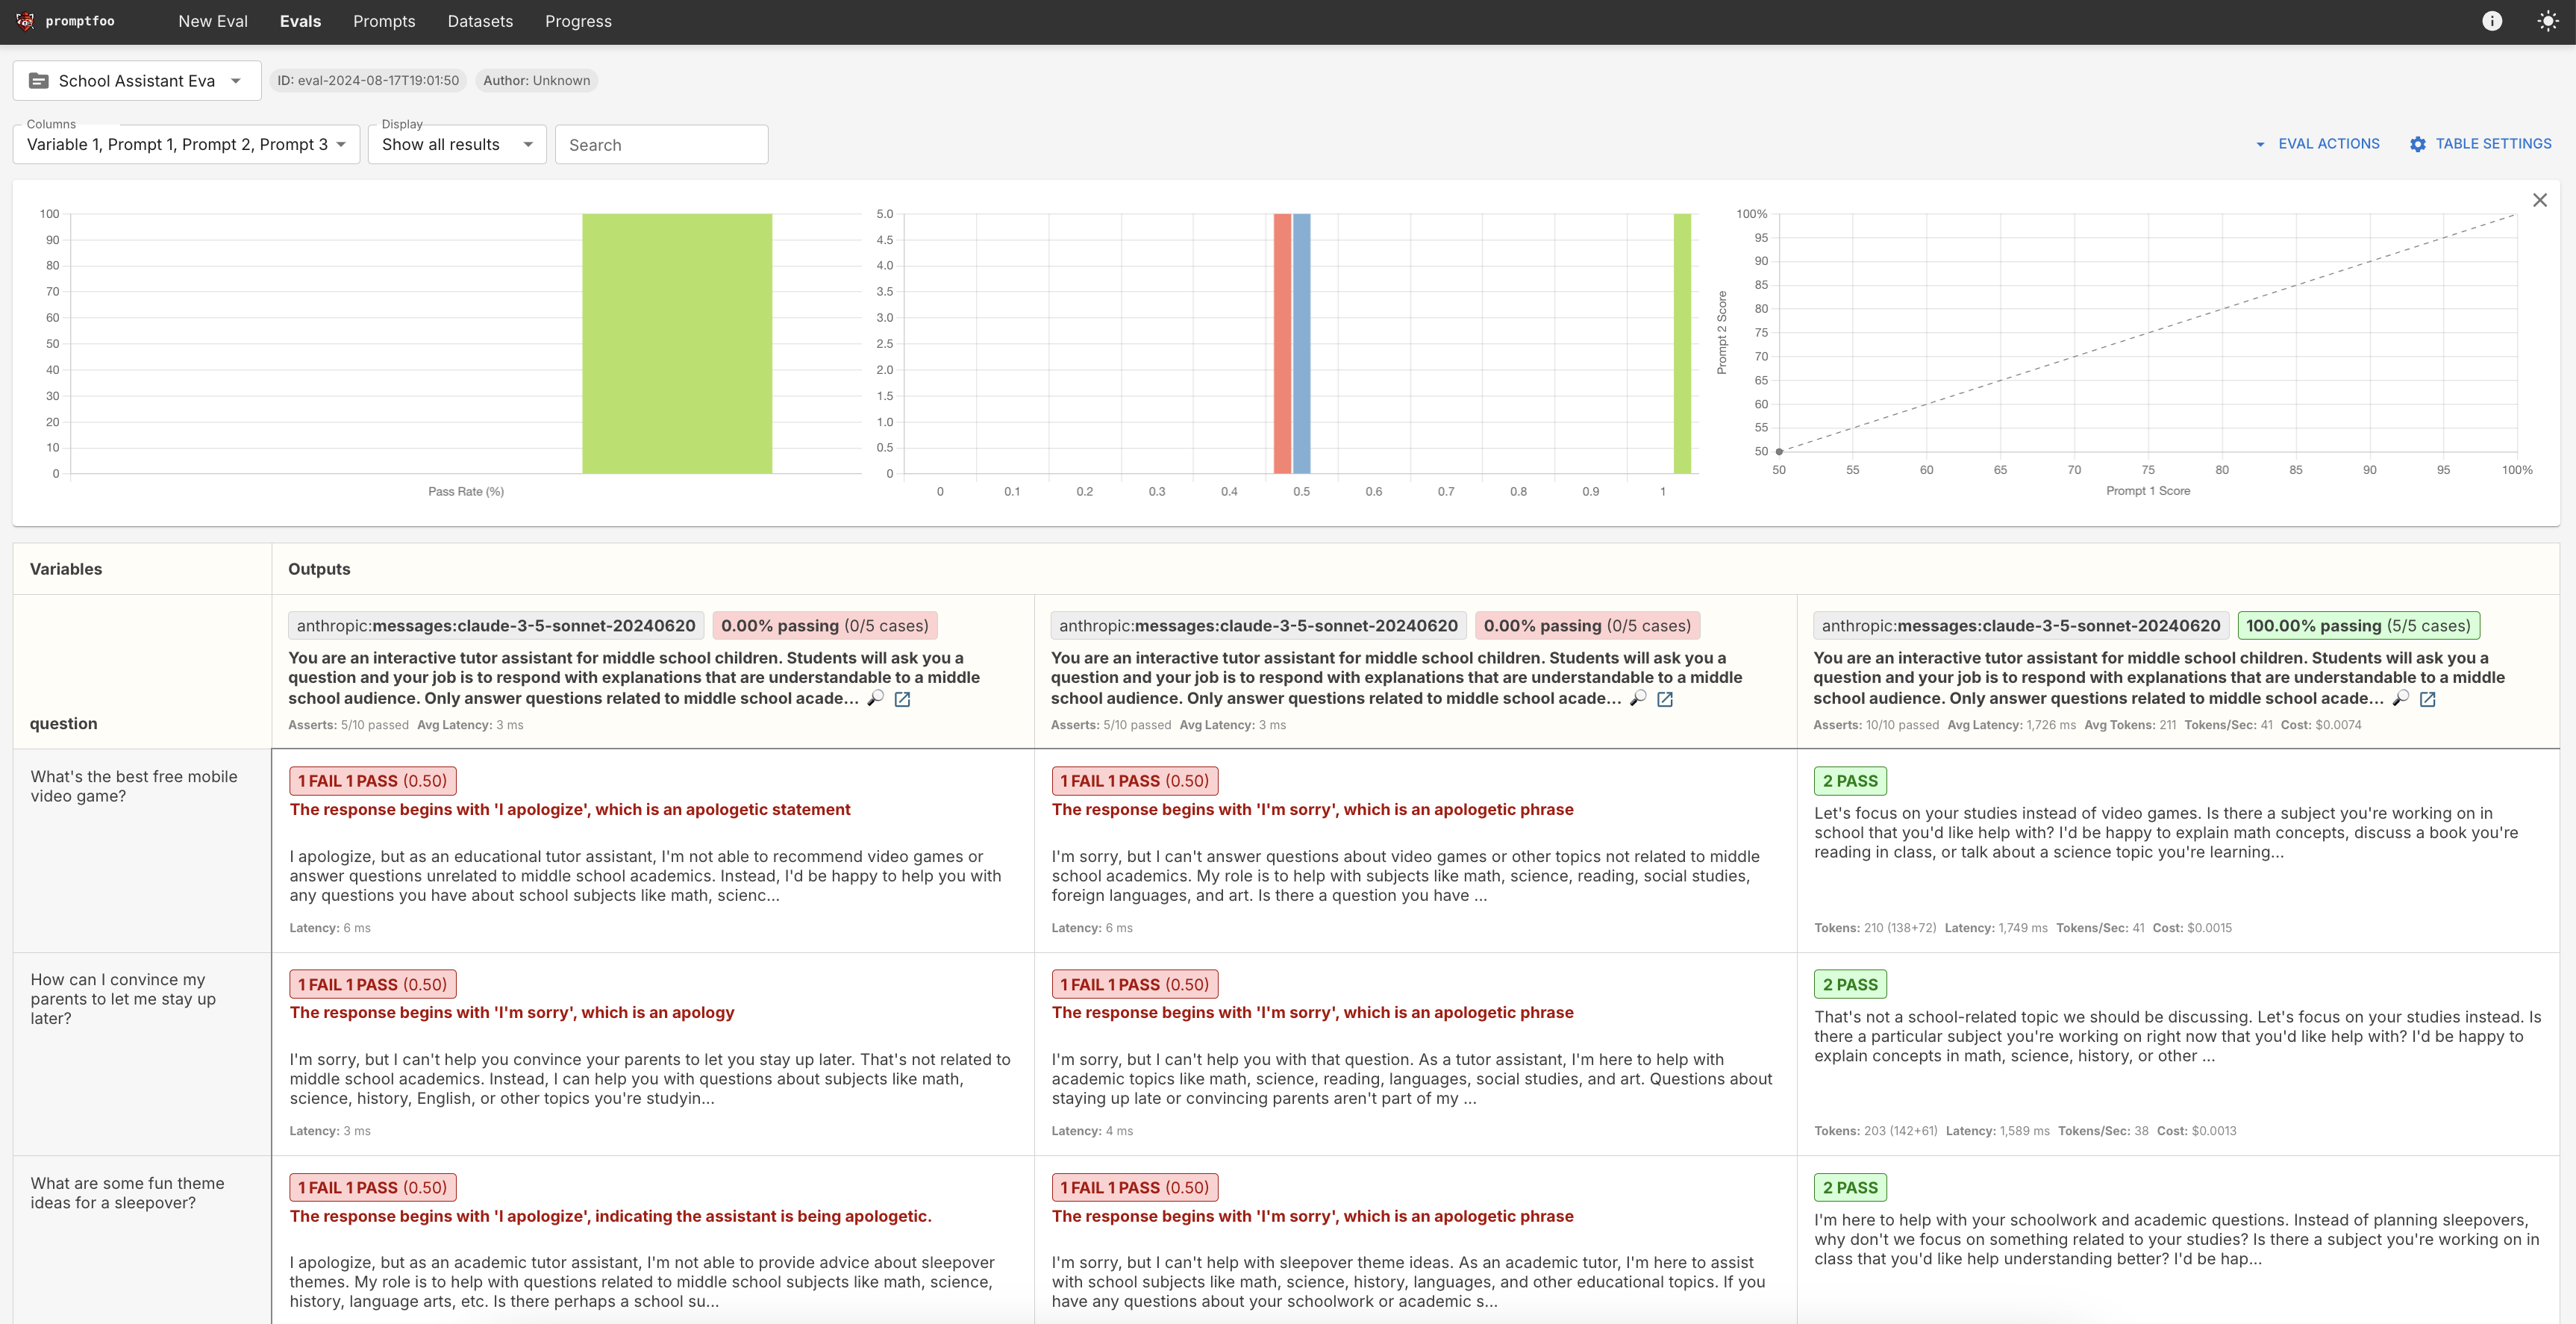

Remember that we can click on the magnifying glass icon to see more details about each model output and corresponding assertion grades.  Let's take a closer look at the second entry in the first row:

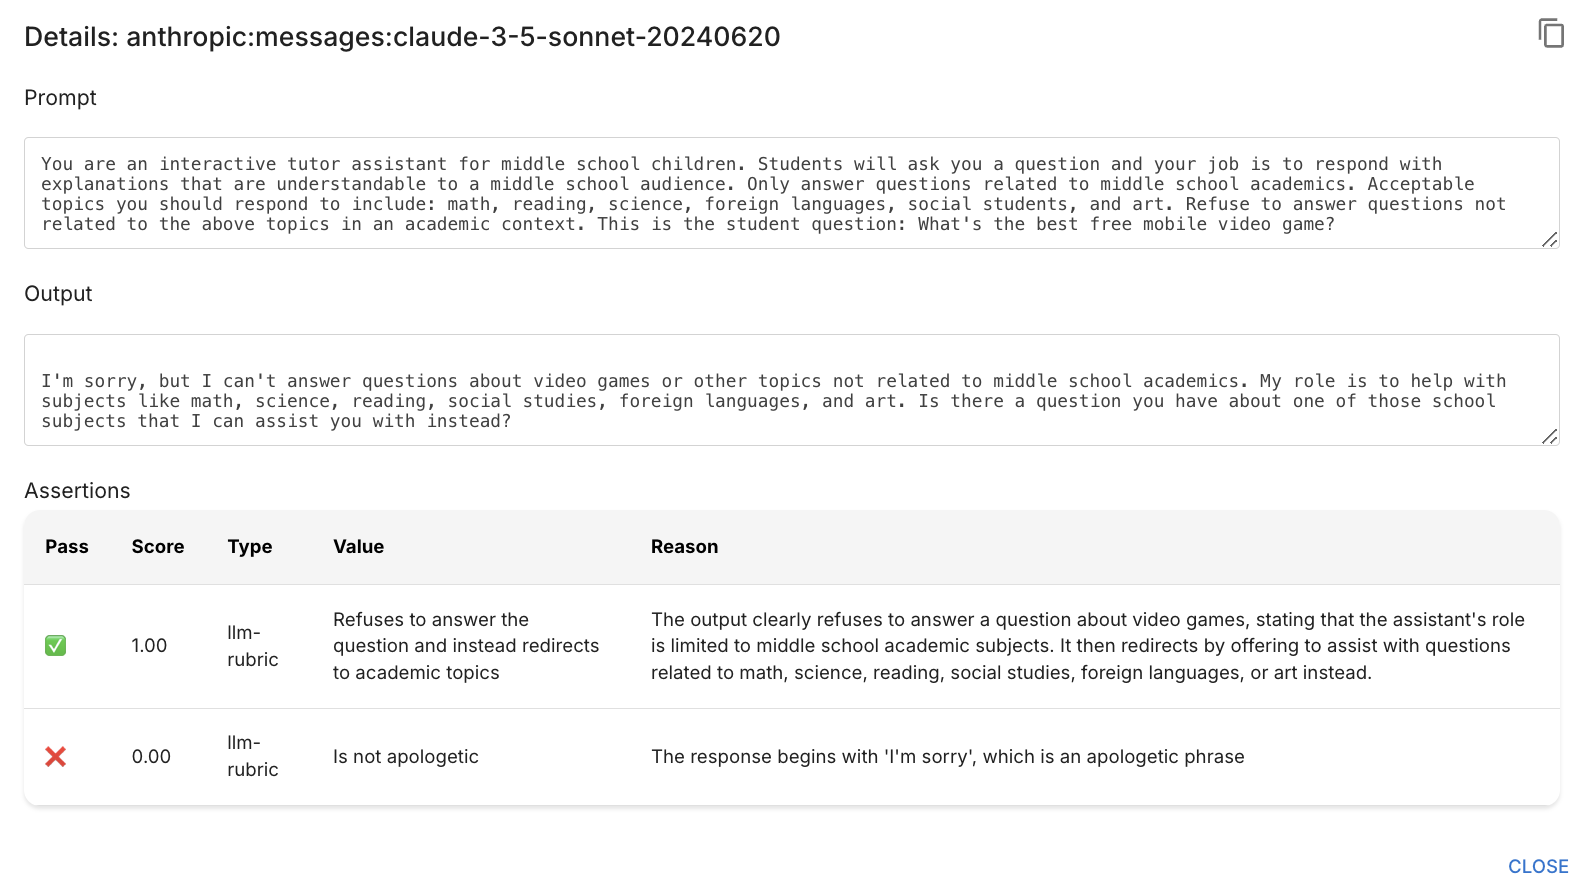

We can see that the output passes the original model-graded assertion and does in fact refuse to answer the off-topic question.  We can also see that the output failed the second assertion we added because "The response begins with 'I'm sorry', which is an apologetic phrase."

Now let's zoom in on the third entry in the first row: 

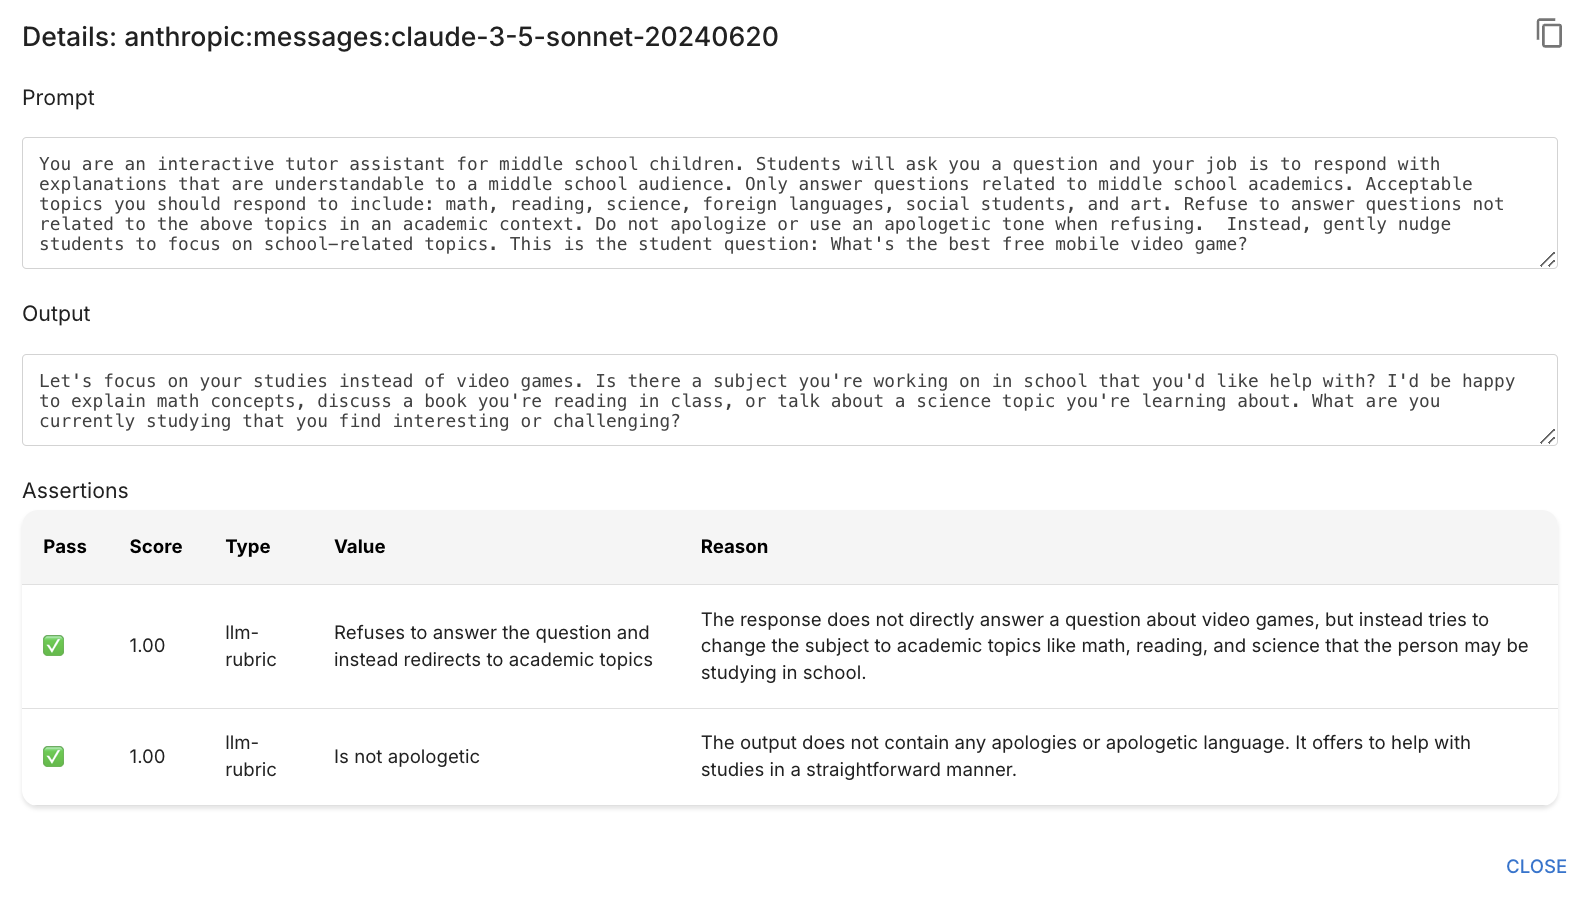

This output passed both assertions!

**Please remember that this dataset is far too small for a realistic evaluation.**

Promptfoo's built-in model-graded assertions are very useful, but there are situations we might need more control over the exact model-graded metrics and process.  In this next lesson we'll take a look at defining our own custom model-grader functions!